<a href="https://colab.research.google.com/github/chunyulin/tf2020ncku/blob/master/0_prepare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get familiar with your free GPU resource
* Colab as the linux box with root premission.
* You cab mount Google Drive to the colab box.
* You can load ipython from Github directly, or checkout the whole github repository (though not really needed).
* All data here are temporary. You would like to save on Google drive, github, or your own server.


In [14]:
# For those familiar with Linux -- You just own a virtual machine with root
!whoami
!pwd
!free -h
!df -h
#!ls /



root
/content
              total        used        free      shared  buff/cache   available
Mem:            12G        1.2G        9.3G        952K        2.3G         11G
Swap:            0B          0B          0B
Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   32G   34G  49% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
tmpfs           6.4G   16K  6.4G   1% /var/colab
/dev/sda1        75G   33G   43G  44% /opt/bin
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G  6.5G  8.6G  43% /content/drive


In [0]:
###  Check your TF version and GPU hardware
import tensorflow as tf
#import tensorflow.compat.v1 as tf
from tensorflow.python.client import device_lib

print ("Using Tensorflow: ", tf.__version__)
print ( device_lib.list_local_devices() )
!nvidia-smi

In [0]:
## All data here are temporary. You would like to save on Google drive, github, or your own server.
# You cab mount Google Drive
# Or just wget from other storage you have, such as S3, HTTP,...

from google.colab import drive
drive.mount('/content/drive')
#!ls /content/drive/'My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [78]:
import os
GIT_USERNAME = "chunyulin"
GIT_REPOSITORY = "test"     # git repository

#GIT_TOKEN = "XXXX"          # only need for private git repository
#GIT_PATH = "https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git"
GIT_PATH = "https://github.com/%s/%s.git" % ( GIT_USERNAME, GIT_REPOSITORY )

!git clone "{GIT_PATH}"     ## {} is only valid in bash
!ls

{GIT_PATH}


# A simple TensorFlow task : MNIST
Example from https://www.tensorflow.org/tutorials/quickstart/advanced

* Load data: `tf.keras.datasets.mnist.load_data()`
* Prepare TF dataset: `tf.data.Dataset`
* Design model: `class MyModel(Model)`
* Perform Training via `tf.keras`

In [0]:
import tensorflow as tf
import numpy as np

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

#a = np.array(range(10)).reshape([2,5])
#a[...,3]

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

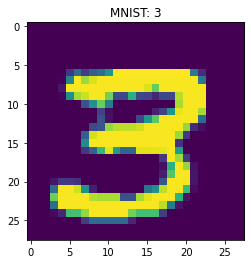

In [95]:
## Before training, let's have a look on the data
import matplotlib.pyplot as plt
ID=111
plt.imshow(x_train[ID,...,0])
plt.title("MNIST: %d" % y_train[ID])
plt.show()

In [0]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense,Conv2D,Flatten
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    #self.conv2 = Conv2D(64, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation='softmax', name="predict")

  def call(self, x):
    x = self.conv1(x)
    #x = self.conv2(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
#tf.compat.v1.reset_default_graph()
model = MyModel()

# Define loss and optimzer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

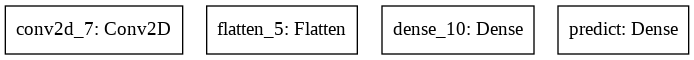

In [116]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png')

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [0]:
## The decorator `@tf.function` introduced for TF2
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [129]:
EPOCHS = 10

train_loss_history = []
test_loss_history = []

for epoch in range(EPOCHS):
  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  train_loss_history.append(np.mean(train_loss.result()))
  test_loss_history.append(np.mean(test_loss.result()))

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

Epoch 1, Loss: 0.13923302292823792, Accuracy: 95.7972412109375, Test Loss: 0.05809866264462471, Test Accuracy: 98.20999908447266
Epoch 2, Loss: 0.04221782088279724, Accuracy: 98.70832824707031, Test Loss: 0.05909726396203041, Test Accuracy: 98.0
Epoch 3, Loss: 0.0235193632543087, Accuracy: 99.26166534423828, Test Loss: 0.056015245616436005, Test Accuracy: 98.0999984741211
Epoch 4, Loss: 0.013707233592867851, Accuracy: 99.55333709716797, Test Loss: 0.0588117316365242, Test Accuracy: 98.36000061035156
Epoch 5, Loss: 0.010071860626339912, Accuracy: 99.66999816894531, Test Loss: 0.05818188562989235, Test Accuracy: 98.50999450683594
Epoch 6, Loss: 0.006807222962379456, Accuracy: 99.76499938964844, Test Loss: 0.06348755955696106, Test Accuracy: 98.3699951171875
Epoch 7, Loss: 0.00523645244538784, Accuracy: 99.81999969482422, Test Loss: 0.07563311606645584, Test Accuracy: 98.31999969482422
Epoch 8, Loss: 0.005172817036509514, Accuracy: 99.8116683959961, Test Loss: 0.07332701981067657, Test Ac

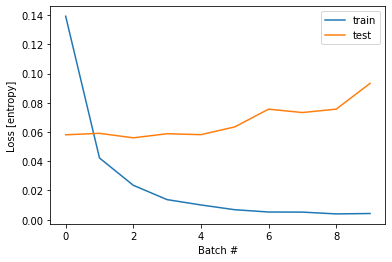

In [130]:
## Monitor the training behavior.
## Can be replace with other tools like TensorBoard.
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')
plt.legend()

(32, 28, 28, 1)
Predict:  9


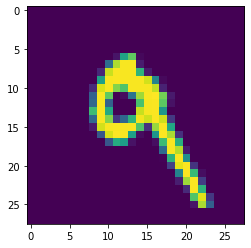

(32, 28, 28, 1)
Predict:  1


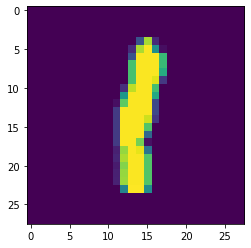

In [131]:
for images,labels in test_ds.take(2):
  print(images.shape)  ## (32, 28, 28, 1)
  im = images[7:8]     ## take 6th image out of the batch.
  print("Predict: ", model(im).numpy().argmax())
  plt.imshow(im.numpy().reshape(28,28))
  plt.show()


In [140]:
# Make prediction via `model.predict()` for multimple sample
for images,labels in test_ds.take(1):
  pre = model.predict(images).argmax(axis=1)
  print( pre)
  print( labels)
  print( pre-labels.numpy())
  

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1]
tf.Tensor([7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1], shape=(32,), dtype=uint8)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [159]:
MODEL_PATH="./model/mnist_v0"
tf.saved_model.save(model, MODEL_PATH)   ##  It seems TF can create an folder if not existed.


INFO:tensorflow:Assets written to: ./model/mnist_v0/assets


In [0]:
GD_PATH="/content/drive/'My Drive'/Colab_shared"
#!cp -r {MODEL_PATH} {GD_PATH}/

## Or, compress the folder to save space before copy
##!tar czvf model.tgz {MODEL_PATH}
##!cp model.tgz {GD_PATH}

### It seems Colab doesn't allow downloading large files
# from google.colab import files
# files.download(MODEL_FILE)


* Let's save it in your github. And open a new colab to use the saved model.
